In [1]:
import numpy as np
import pandas as pd

import scipy.stats as stats
import scipy
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
from pprint import pprint

import requests

from bs4 import BeautifulSoup

import json
import time
import copy
from collections import Counter
import re
import string

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
#loop 3: improve model with SnowBall stemming and ngram_range(1,2). Perform EDA with roc curve
#loop 4: Expand stop words, custom n-grams, include count vectorizor data?

In [2]:
corpus = pd.read_csv("data/booksummaries/summaries&genres.csv")
corpus['Summary'] = corpus['Summary'].str.lower()
# corpus['Summary'].str.replace("starship", "spaceship");

In [3]:
y = corpus['scifi?'] #create targets

In [4]:
#loop 3: improve model with stemming. Perform EDA with roc curve
from nltk.util import ngrams
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
from nltk.stem.snowball import  SnowballStemmer
from nltk.stem import WordNetLemmatizer
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB as SKMultinomialNB
import unicodedata
from nltk.corpus import stopwords

In [5]:
stemmer = SnowballStemmer('english')

In [6]:
corpus['Stemmed_Summary'] = corpus['Summary'].apply(lambda doc: [stemmer.stem(word) for word in word_tokenize(doc)])

In [7]:
corpus['Stemmed_Summary'] = corpus['Stemmed_Summary'].str.join(' ')
corpus['Stemmed_Summary'].str.replace('starship', 'spaceship')

0        old major , the old boar on the manor farm , c...
1        alex , a teenag live in near-futur england , l...
2        the text of the plagu is divid into five part ...
3        the novel posit that space around the milki wa...
4        the book tell the stori of paul bäumer , a ger...
                               ...                        
12836    the stori start with former govern agent , fra...
12837    the seri follow the charact of nick stone , an...
12838    the reader first meet rapp while he is do a co...
12839    the book follow veri rough chronolog order , w...
12840    makar devushkin and varvara dobroselova are se...
Name: Stemmed_Summary, Length: 12841, dtype: object

In [8]:
list(ngrams(['time','machine','technical','advancements','higher','plane','travel'],2))

[('time', 'machine'),
 ('machine', 'technical'),
 ('technical', 'advancements'),
 ('advancements', 'higher'),
 ('higher', 'plane'),
 ('plane', 'travel')]

In [9]:
X_train, X_test, y_train, y_test = train_test_split(corpus, y,stratify=y) #split data with all columns/info

In [10]:
from nltk.corpus import stopwords
sw = stopwords.words('english') #setup stop words
sw.extend(['use','father','discover','planet'])
tfidf_vec = TfidfVectorizer(stop_words=sw)
#ngram_range=(1,2) reduced accuracy. 

In [11]:
X_train_nlp = tfidf_vec.fit_transform(X_train['Stemmed_Summary'])#use only summary column, train model

In [12]:
from sklearn.ensemble import RandomForestClassifier

In [13]:
rf = RandomForestClassifier(max_depth=200, max_features = 2000, oob_score=True)
#tried depths of 100, 200, and 500
#max features 'auto' and 2000: 2000 is better but was perfect with train data...

In [14]:
X_train_nlp = tfidf_vec.fit_transform(X_train['Stemmed_Summary'])
X_test_nlp = tfidf_vec.transform(X_test['Stemmed_Summary'])

In [15]:
rf.fit(X_train_nlp, y_train)

RandomForestClassifier(max_depth=200, max_features=2000, oob_score=True)

In [16]:
TFIDF_train_score = rf.score(X_train_nlp, y_train)
TFIDF_test_score = rf.score(X_test_nlp, y_test)

In [17]:
print(TFIDF_train_score)
print(TFIDF_test_score)

1.0
0.8754282155091871


Text(0.5, 0, 'Word Scores')

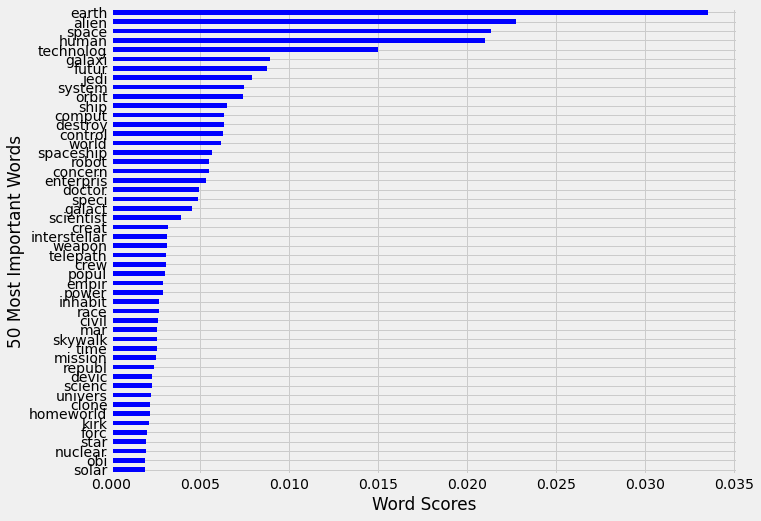

In [18]:
fig, ax = plt.subplots()
feat_scores = pd.Series(rf.feature_importances_, index=tfidf_vec.get_feature_names())
feat_scores = feat_scores.sort_values()
ax = feat_scores[-50:].plot(kind='barh',figsize=(10,8),color='b')
ax.set_ylabel('50 Most Important Words')
ax.set_xlabel('Word Scores')
# fig.savefig('/home/thomas/DSI_ii/cap_stones/DSI_CS3/images/body_scores.png',dpi=None, facecolor='w', edgecolor='w',
#         orientation='portrait', papertype=None, format=None,
#         transparent=False, bbox_inches='tight', pad_inches=0.2,
#         frameon=None, metadata=None)

In [19]:
#Confusion Matrix
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
predictions = rf.predict(X_test_nlp)
cf = pd.crosstab(y_test, predictions)
print(cf)

col_0   False  True 
scifi?              
False    2419     70
True      330    392


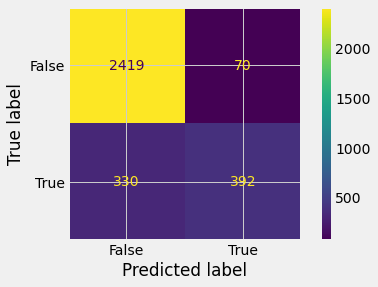

In [20]:
plot_confusion_matrix(rf, X_test_nlp, y_test)

In [27]:
# Auto Max Features precision = .915 recall = .088
# tp = 214
# tn = 436
# fp = 20
# fn = 2220

#Depth set to 2000
tp = 392
tn = 330
fp = 70
fn = 2419
recall = tp/(tp+fn)
precision = tp/(tp+fp)
print(recall, precision)

0.13945215225898258 0.8484848484848485


In [22]:
rf.predict(X_test_nlp)

array([False,  True,  True, ..., False,  True, False])

In [23]:
mislabeled = X_test[y_test != predictions]
# mislabeled['Summary'].values

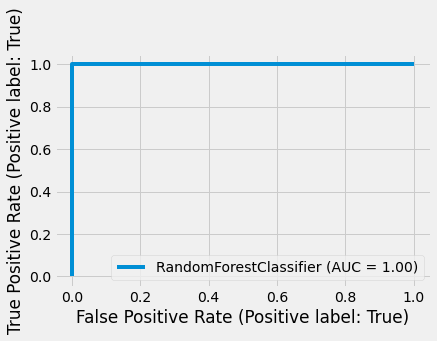

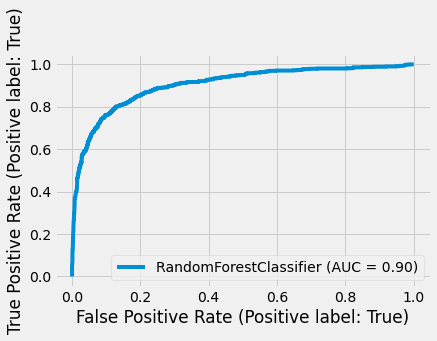

In [24]:
from sklearn.metrics import plot_roc_curve
plot_roc_curve(rf,X_train_nlp,y_train)
# plt.savefig('/home/thomas/DSI_ii/cap_stones/DSI_CS2/images/Title_roc_train.png',dpi=None, facecolor='w', edgecolor='w',
#         orientation='portrait', papertype=None, format=None,
#         transparent=False, bbox_inches='tight', pad_inches=0.2,
#         frameon=None, metadata=None)
plot_roc_curve(rf,X_test_nlp,y_test)
# plt.savefig('/home/thomas/DSI_ii/cap_stones/DSI_CS2/images/Title_roc_test.png',dpi=None, facecolor='w', edgecolor='w',
#         orientation='portrait', papertype=None, format=None,
#         transparent=False, bbox_inches='tight', pad_inches=0.2,
#         frameon=None, metadata=None)